In [1]:

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

from keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar10
from keras.utils import plot_model
from keras import backend as K

Using TensorFlow backend.


In [0]:
def rgb2gray(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 15s 0us/step


In [4]:
X_train.shape

(50000, 32, 32, 3)

In [5]:
type(X_train)

numpy.ndarray

In [0]:
img_size = X_train.shape[1]
channel = 3

In [0]:
X_train_gray = []
X_test_gray = []

for i in range(X_train.shape[0]):
  img = X_train[i]
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  X_train_gray.append(img)
  
for i in range(X_test.shape[0]):
  img = X_test[i]
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  X_test_gray.append(img)

In [0]:
X_train_gray = np.asarray(X_train_gray)
X_test_gray = np.asarray(X_test_gray)

In [0]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
X_train_gray = X_train_gray.astype('float32')/255
X_test_gray = X_test_gray.astype('float32')/255

In [0]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, channel)
X_test = X_test.reshape(X_test.shape[0], img_size, img_size, channel)
X_train_gray = X_train_gray.reshape(X_train_gray.shape[0], img_size, img_size, 1)
X_test_gray = X_test_gray.reshape(X_test_gray.shape[0], img_size, img_size, 1)

In [0]:
input_shape = (img_size, img_size, 1)
latent_dim =256

In [12]:
inputs = Input(shape = input_shape, name = 'encoder_input')
x = inputs
x = Conv2D(64, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)
x = Conv2D(128, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)
x = Conv2D(256, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
shape = K.int_shape(x)

In [0]:
x = Flatten()(x)
latent = Dense(latent_dim, name = 'latent_vector')(x)

In [0]:
encoder = Model(inputs, latent, name = 'encoder')

In [16]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
_________________________________________________________________


In [0]:
latent_inputs = Input(shape = (latent_dim,), name = 'decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [0]:
x = Conv2DTranspose(256, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(128, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(64, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)

In [0]:
outputs = Conv2DTranspose(3, (3,3), activation = 'sigmoid', padding = 'same', name = 'decoder_output')(x)

In [0]:
decoder = Model(latent_inputs, outputs, name = 'decoder')

In [21]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              1052672   
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 64)        73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 3)         1731      
Total para

In [0]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name = 'autoencoder')

In [23]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 256)               1418496   
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         2013315   
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


In [0]:
lr_reducer = ReduceLROnPlateau(factor = np.sqrt(0.1), cooldown = 0, patience = 5, verbose = 1, min_lr = 0.5e-6)

In [0]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [0]:
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

In [0]:
callbacks = [lr_reducer, checkpoint]

In [0]:
autoencoder.compile(loss = 'mse', optimizer = 'Adam', metrics = ['accuracy'])

In [29]:
autoencoder.fit(X_train_gray, X_train, validation_data = (X_test_gray, X_test),epochs = 30, batch_size = 32, callbacks = callbacks)

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 49s 972us/step - loss: 0.0153 - acc: 0.4879 - val_loss: 0.0107 - val_acc: 0.5139

Epoch 00001: val_loss improved from inf to 0.01070, saving model to /content/saved_models/colorized_ae_model.001.h5
Epoch 2/30
50000/50000 [==============================] - 43s 864us/step - loss: 0.0100 - acc: 0.5067 - val_loss: 0.0093 - val_acc: 0.5213

Epoch 00002: val_loss improved from 0.01070 to 0.00930, saving model to /content/saved_models/colorized_ae_model.002.h5
Epoch 3/30
50000/50000 [==============================] - 43s 866us/step - loss: 0.0090 - acc: 0.5128 - val_loss: 0.0087 - val_acc: 0.5337

Epoch 00003: val_loss improved from 0.00930 to 0.00871, saving model to /content/saved_models/colorized_ae_model.003.h5
Epoch 4/30
50000/50000 [==============================] - 43s 860us/step - loss: 0.0084 - acc: 0.5170 - val_loss: 0.0084 - val

In [0]:
x_decoded = autoencoder.predict(X_test_gray)

In [0]:
autoencoder.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5') 

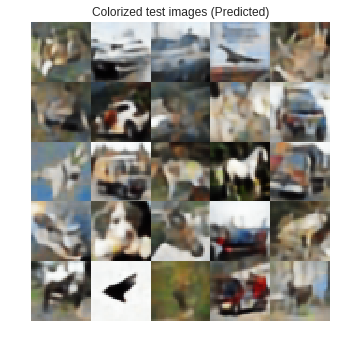

In [33]:
imgs = x_decoded[:25]
imgs = imgs.reshape((5, 5, img_size, img_size, channel))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
#plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()


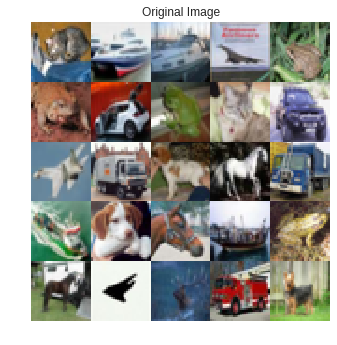

In [35]:
imgs = X_test[:25]
imgs = imgs.reshape((5, 5, img_size, img_size, channel))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Original Image')
plt.imshow(imgs, interpolation='none')
#plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()